In [1]:
# Preliminaries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import networkx as nx
import theano
import theano.tensor as tt
import math 

import theano
# Preliminaries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math 

import pandas as pd 
import matplotlib
import matplotlib.pylab as plt 
import seaborn as sns 
import numpy as np
from math import *
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
from matplotlib.patches import Ellipse
%matplotlib inline
from scipy.stats import linregress
from matplotlib.offsetbox import AnchoredText
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [2]:
# Load the data
g1 = nx.read_graphml('../../fep-maps-noexp/graphml/CDK2_Blake_replicate2_noexp.graphml')
g2 = nx.read_graphml('../../fep-maps-noexp/graphml/ERK2_Blake_replicate2_noexp.graphml')
g3 = nx.read_graphml('../../fep-maps/graphml/CDK2_Blake_samegraph_051118_seed2_out.graphml')
g4 = nx.read_graphml('../../fep-maps/graphml/ERK2_Blake_samegraph_051118_seed2_out.graphml')
list_of_graphs = [g1, g2]
g1.remove_node('9')
g2.remove_node('9')
g3.remove_node('9')
g4.remove_node('9')

In [3]:
nligands = len(g1.nodes)
print(nligands)
ligand_index = { str(node) : index for (index, node) in enumerate(g1.nodes) }
reference_ligand = [ str(node) for node in g1.nodes ][0] # We will use the same reference ligand in all calculations
print('Reference ligand: {}'.format(reference_ligand))

nedges = len(g1.edges)
print(nedges)
G_to_DeltaG = np.zeros([nedges, nligands])
DeltaG_BAR_target1_complex_calc = np.zeros([nedges])
dDeltaG_BAR_target1_complex_calc = np.zeros([nedges])
DeltaG_BAR_target1_solvent_calc = np.zeros([nedges])
dDeltaG_BAR_target1_solvent_calc = np.zeros([nedges])
DeltaDeltaG_exp_target1 = np.zeros([nedges])
DeltaDeltaG_CycleClosure_ij_target1 = np.zeros([nedges])
DeltaDeltaG_CycleClosure_ij_target2 = np.zeros([nedges])
for edge_index, edge in enumerate(g1.edges):
    ligand_i, ligand_j = edge
    #if ligand_i != reference_ligand:
    i = ligand_index[ligand_i]
    G_to_DeltaG[edge_index,i] = -1.0
    #if ligand_j != reference_ligand:
    j = ligand_index[ligand_j]
    G_to_DeltaG[edge_index,j] = +1.0
    
    DeltaG_BAR_target1_complex_calc[edge_index] = g1.edges[edge]['complex_dg_val']
    dDeltaG_BAR_target1_complex_calc[edge_index] = g1.edges[edge]['complex_dg_unc']
    DeltaG_BAR_target1_solvent_calc[edge_index] = g1.edges[edge]['solvent_dg_val']
    dDeltaG_BAR_target1_solvent_calc[edge_index] = g1.edges[edge]['solvent_dg_unc']
    DeltaDeltaG_exp_target1[edge_index] = g1.edges[edge]['exp_ddg']
    DeltaDeltaG_CycleClosure_ij_target1[edge_index] = g1.edges[edge]['ccc_ddg_val']


DeltaG_BAR_target2_complex_calc = np.zeros([nedges])
dDeltaG_BAR_target2_complex_calc = np.zeros([nedges])
DeltaG_BAR_target2_solvent_calc = np.zeros([nedges])
dDeltaG_BAR_target2_solvent_calc = np.zeros([nedges])
DeltaDeltaG_exp_target2 = np.zeros([nedges])
for edge_index, edge in enumerate(g2.edges):
    ligand_i, ligand_j = edge
    DeltaG_BAR_target2_complex_calc[edge_index] = g2.edges[edge]['complex_dg_val']
    dDeltaG_BAR_target2_complex_calc[edge_index] = g2.edges[edge]['complex_dg_unc']
    DeltaG_BAR_target2_solvent_calc[edge_index] = g2.edges[edge]['solvent_dg_val']
    dDeltaG_BAR_target2_solvent_calc[edge_index] = g2.edges[edge]['solvent_dg_unc']
    DeltaDeltaG_exp_target2[edge_index] = g2.edges[edge]['exp_ddg']
    DeltaDeltaG_CycleClosure_ij_target2[edge_index] = g2.edges[edge]['ccc_ddg_val']

DeltaG_exp_1 = np.zeros([nligands])
for node_index,node in enumerate(g1.nodes):
    DeltaG_exp_1[node_index] = g1.nodes[node]['exp_dg']

DeltaG_exp_2 = np.zeros([nligands])
for node_index,node in enumerate(g2.nodes):
    DeltaG_exp_2[node_index] = g2.nodes[node]['exp_dg']
sd_G = np.zeros([nligands])
for i,num in enumerate(sd_G): 
    if i == 0:
        sd_G[i] = 1.0
    else: 
        sd_G[i] = 25.0
sd_G

18
Reference ligand: 17
25


array([ 1., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25.])

In [4]:
model = pm.Model()
with model:
    experimental_error=0.3
    # Implement absolute G for target 1 
    G_FEP_i_target1_complex = pm.Normal('G_FEP_i_target1_complex', mu=0.0, sd=sd_G, shape=(nligands,))
    G_FEP_i_target1_solvent = pm.Normal('G_FEP_i_target1_solvent', mu=0.0, sd=sd_G, shape=(nligands,))
    alpha = pm.HalfFlat('alpha')
    
    # Correction term for dummy atoms 
    c_FEP_ij_target1 = pm.Normal('c_FEP_ij_target1', mu=0.0, sd=25.0, shape=(nedges,))
    
    # Calculated BAR Delta G for each edge and phase for target 1
    DeltaG_BAR_target1_complex = pm.Normal('DeltaG_BAR_target1_complex', mu=tt.dot(G_to_DeltaG, G_FEP_i_target1_complex)+c_FEP_ij_target1, 
                                           sd=alpha*dDeltaG_BAR_target1_complex_calc, observed=DeltaG_BAR_target1_complex_calc, shape=(nedges,))
    DeltaG_BAR_target1_solvent = pm.Normal('DeltaG_BAR_target1_solvent', mu=tt.dot(G_to_DeltaG, G_FEP_i_target1_solvent)+c_FEP_ij_target1, 
                                           sd=alpha*dDeltaG_BAR_target1_solvent_calc, observed=DeltaG_BAR_target1_solvent_calc, shape=(nedges,))
    DeltaDeltaG_FEP_ij_target1 = pm.Deterministic('DeltaDeltaG_FEP_ij_target1', 
                                                  tt.dot(G_to_DeltaG, G_FEP_i_target1_complex) - tt.dot(G_to_DeltaG, G_FEP_i_target1_solvent))
    
    # Calculated BAR delta G for each edge and phase for target 2 
    G_FEP_i_target2_complex = pm.Normal('G_FEP_i_target2_complex', mu=0.0, sd=sd_G, shape=[nligands,])
    G_FEP_i_target2_solvent = pm.Normal('G_FEP_i_target2_solvent', mu=0.0, sd=sd_G, shape=[nligands,])
    c_FEP_ij_target2 = pm.Normal('c_FEP_ij_target2', mu=0.0, sd=25.0, shape=[nedges])
    DeltaG_BAR_target2_complex = pm.Normal('DeltaG_BAR_target2_complex', mu=tt.dot(G_to_DeltaG, G_FEP_i_target2_complex)+c_FEP_ij_target2, 
                                           sd=alpha*dDeltaG_BAR_target2_complex_calc, observed=DeltaG_BAR_target2_complex_calc, shape=(nedges,))
    DeltaG_BAR_target2_solvent = pm.Normal('DeltaG_BAR_target2_solvent', mu=tt.dot(G_to_DeltaG, G_FEP_i_target2_solvent)+c_FEP_ij_target2, 
                                           sd=alpha*dDeltaG_BAR_target2_solvent_calc, observed=DeltaG_BAR_target2_solvent_calc, shape=(nedges,))
    DeltaDeltaG_FEP_ij_target2 = pm.Deterministic('DeltaDeltaG_FEP_ij_target2', 
                                                  tt.dot(G_to_DeltaG, G_FEP_i_target2_complex) - tt.dot(G_to_DeltaG, G_FEP_i_target2_solvent))
        
    
    # True and Experimental delta G for each target 
    DeltaG_true_exp_i_target1 = pm.Normal('DeltaG_true_exp_i_target1', mu=0.0, sd=50.0, shape=(nligands,))
    DeltaG_obs_exp_i_target1 = pm.Normal('DeltaG_obs_exp_i_target1', mu=DeltaG_true_exp_i_target1, sd=experimental_error, shape=(nligands,), observed=DeltaG_exp_1)
    DeltaDeltaG_true_exp_ij_target1 = pm.Deterministic('DeltaDeltaG_true_exp_ij_target1', tt.dot(G_to_DeltaG, DeltaG_true_exp_i_target1))

    DeltaG_true_exp_i_target2 = pm.Normal('DeltaG_true_exp_i_target2', mu=0.0, sd=50.0, shape=(nligands,))
    DeltaG_obs_exp_i_target2 = pm.Normal('DeltaG_obs_exp_i_target2', mu=DeltaG_true_exp_i_target2, sd=experimental_error, shape=(nligands,), observed=DeltaG_exp_2)
    DeltaDeltaG_true_exp_ij_target2 = pm.Deterministic('DeltaDeltaG_true_exp_ij_target2', tt.dot(G_to_DeltaG, DeltaG_true_exp_i_target2))
    
     # Compute estimate of absolute binding free energies (with additive arbitrary offset)
    DeltaG_FEP_i_target1_no_offset = pm.Deterministic('DeltaG_FEP_i_target1_no_offset', G_FEP_i_target1_complex - G_FEP_i_target1_solvent)
    DeltaG_FEP_i_target2_no_offset = pm.Deterministic('DeltaG_FEP_i_target2_no_offset', G_FEP_i_target2_complex - G_FEP_i_target2_solvent)

    # Compute best-case shifted offsets of absolute binding free energies (with Schrodinger style offset)
    DeltaG_FEP_i_target1_schrodinger_offset = pm.Deterministic('DeltaG_FEP_i_target1_schrodinger_offset', DeltaG_FEP_i_target1_no_offset + DeltaG_true_exp_i_target1.mean() - DeltaG_FEP_i_target1_no_offset.mean())
    DeltaG_FEP_i_target2_schrodinger_offset = pm.Deterministic('DeltaG_FEP_i_target2_schrodinger_offset', DeltaG_FEP_i_target2_no_offset + DeltaG_true_exp_i_target2.mean() - DeltaG_FEP_i_target2_no_offset.mean())
    
    # Compute best-case dG errors 
    epsilon_i_target1_schrodinger = pm.Deterministic('epsilon_i_target1_schrodinger', DeltaG_FEP_i_target1_schrodinger_offset - DeltaG_true_exp_i_target1)
    epsilon_i_target2_schrodinger = pm.Deterministic('epsilon_i_target2_schrodinger', DeltaG_FEP_i_target2_schrodinger_offset - DeltaG_true_exp_i_target2)
    
    #error_likelihood = pm.DensityDist('error_liklihood', logp, observed={'rho':rho, 'sigma':sigma_FEP, 'epsilon_a':error_target1, 'epsilon_b':error_target2}, shape=(nedges,))
    rho_schrodinger = pm.Deterministic('rho_schrodinger', ((((epsilon_i_target1_schrodinger - epsilon_i_target1_schrodinger.mean()) * (epsilon_i_target2_schrodinger - epsilon_i_target2_schrodinger.mean())).mean()) /
                                   (epsilon_i_target1_schrodinger.std() * epsilon_i_target2_schrodinger.std())))
    
    
    # Compute free energy differences between all pairs of ligands    
    DeltaDeltaG_FEP_allpairs_ij_target1 = pm.Deterministic('DeltaDeltaG_FEP_allpairs_ij_target1', DeltaG_FEP_i_target1_no_offset.dimshuffle(0, 'x') - DeltaG_FEP_i_target1_no_offset.dimshuffle('x', 0))
    DeltaDeltaG_FEP_allpairs_ij_target2 = pm.Deterministic('DeltaDeltaG_FEP_allpairs_ij_target2', DeltaG_FEP_i_target2_no_offset.dimshuffle(0, 'x') - DeltaG_FEP_i_target2_no_offset.dimshuffle('x', 0))
     
    # Compute experimental ddG differences for all pairs of ligands
    DeltaDeltaG_true_exp_allpairs_ij_target1 = pm.Deterministic('DeltaDeltaG_true_exp_allpairs_ij_target1', DeltaG_true_exp_i_target1.dimshuffle(0, 'x') - DeltaG_true_exp_i_target1.dimshuffle('x', 0))
    DeltaDeltaG_true_exp_allpairs_ij_target2 = pm.Deterministic('DeltaDeltaG_true_exp_allpairs_ij_target2', DeltaG_true_exp_i_target2.dimshuffle(0, 'x') - DeltaG_true_exp_i_target2.dimshuffle('x', 0))

    # Compute ddG errors for all pairs of ligands
    epsilon_ij_target1 = pm.Deterministic('epsilon_ij_target1', DeltaDeltaG_FEP_allpairs_ij_target1 - DeltaDeltaG_true_exp_allpairs_ij_target1)
    epsilon_ij_target2 = pm.Deterministic('epsilon_ij_target2', DeltaDeltaG_FEP_allpairs_ij_target2 - DeltaDeltaG_true_exp_allpairs_ij_target2)
    rho_allpairs = pm.Deterministic('rho_allpairs', ((((epsilon_ij_target1 - epsilon_ij_target1.mean()) * (epsilon_ij_target2 - epsilon_ij_target2.mean())).mean()) /
                                   (epsilon_ij_target1.std() * epsilon_ij_target2.std())))
    
    

In [5]:
with model:
    trace = pm.load_trace('CDK2-ERK2-trace_ccparameter/')

In [6]:
nedges = len(g1.edges)
nligands = len(g1.nodes)
reference = '6'
print(nligands)
DeltaG_exp_1 = np.zeros([nligands])
DeltaG_CC_1 = np.zeros([nligands])
dDeltaG_stat_1 = np.zeros([nligands])
dDeltaG_systematic_1 = np.zeros([nligands])
for node_index,node in enumerate(g1.nodes):
    DeltaG_exp_1[node_index] = g3.nodes[node]['exp_dg'] - g3.nodes[reference]['exp_dg']
    DeltaG_CC_1[node_index] = g1.nodes[node]['pred_dg_val'] - g1.nodes[reference]['pred_dg_val']
    dDeltaG_stat_1[node_index] = np.std(trace['DeltaDeltaG_FEP_allpairs_ij_target1'][:,13,node_index])
    dDeltaG_systematic_1[node_index] = abs(np.mean(trace['epsilon_ij_target1'][:,13,node_index]))

DeltaG_CC_2 = np.zeros([nligands])
dDeltaG_stat_2 = np.zeros([nligands])
DeltaG_exp_2 = np.zeros([nligands])
dDeltaG_systematic_2 = np.zeros([nligands])
for node_index,node in enumerate(g2.nodes):
    DeltaG_exp_2[node_index] = g4.nodes[node]['exp_dg'] - g4.nodes[reference]['exp_dg']
    DeltaG_CC_2[node_index] = g2.nodes[node]['pred_dg_val'] - g2.nodes[reference]['pred_dg_val']
    dDeltaG_stat_2[node_index] = np.std(trace['DeltaDeltaG_FEP_allpairs_ij_target2'][:,13,node_index])
    dDeltaG_systematic_2[node_index] = abs(np.mean(trace['epsilon_ij_target2'][:,13,node_index]))

rho = np.mean(trace['rho_allpairs'])
selectivity_pred_set1 = DeltaG_CC_2 - DeltaG_CC_1
selectivity_exp_set1 = DeltaG_exp_2 - DeltaG_exp_1 
selectivity_pred_unc_set1 = np.sqrt(dDeltaG_stat_2 ** 2 + dDeltaG_stat_1 ** 2)
selectivity_pred_systematic_set1 = np.sqrt(dDeltaG_systematic_2 ** 2 + dDeltaG_systematic_1 ** 2 - (2* rho *dDeltaG_systematic_1 * dDeltaG_systematic_2) + dDeltaG_stat_2 ** 2 + dDeltaG_stat_1 ** 2)

18


In [7]:
error_experiment = []
nsamples = nligands
for x in range(nligands): 
    error_experiment.append(np.sqrt(0.3**2 + 0.3**2))
error_experiment = np.asarray(error_experiment)

mue_selectivity = []
rmse_selectivity = []

mue_1 = []
rmse_1 = []

mue_2 = []
rmse_2 = []
r_values = []


nreplicates = 10000
for replicate in range(nreplicates):
    # bootstrapping over the indices 
    samples = np.random.choice(np.arange(nsamples), nsamples)
    
    # generating bootstrapped replicates
    exp_replicate_1 = DeltaG_exp_1[samples] 
    pred_replicate_1 = DeltaG_CC_1[samples]
    exp_replicate_2 = DeltaG_exp_2[samples] 
    pred_replicate_2 = DeltaG_CC_2[samples]
    
    # Calculate predicted selectivity 
    selectivity_experiment = exp_replicate_2 - exp_replicate_1
    selectivity_predicted = pred_replicate_2 - pred_replicate_1
    
    
    # calculate bootstrapped statistics for selectivity
    rmse_selectivity_val = math.sqrt(mean_squared_error(selectivity_experiment, selectivity_predicted))
    mue_selectivity_val = mean_absolute_error(selectivity_experiment, selectivity_predicted)
    mue_selectivity.append(mue_selectivity_val)
    rmse_selectivity.append(rmse_selectivity_val)
    
    # calculate bootstrapped statistics for target 1
    rmse_1_val = math.sqrt(mean_squared_error(exp_replicate_1, pred_replicate_1))
    mue_1_val = mean_absolute_error(exp_replicate_1, pred_replicate_1)
    mue_1.append(mue_1_val)
    rmse_1.append(rmse_1_val)
    
    # calculate bootstrapped statistics for target 1
    rmse_2_val = math.sqrt(mean_squared_error(exp_replicate_2, pred_replicate_2))
    mue_2_val = mean_absolute_error(exp_replicate_2, pred_replicate_2)
    mue_2.append(mue_2_val)
    rmse_2.append(rmse_2_val)
    
    # R values 
    error_target1 = exp_replicate_1 - pred_replicate_1
    error_target2 = exp_replicate_2 - pred_replicate_2
    slope, intercept, r_value, p_value, std_err = linregress(error_target2, error_target1)
    r_values.append(r_value)
    
    

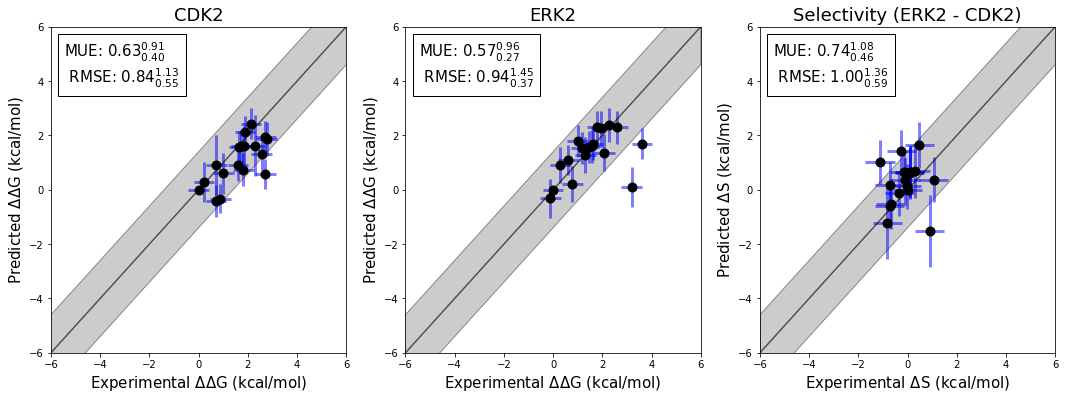

In [8]:
fig = plt.figure(figsize=(18,6))
x = np.array(range(-14, 7))
y = np.array(range(-14, 7))
ax = fig.add_subplot(1,3,1)
edge_color = matplotlib.colors.colorConverter.to_rgba('blue', alpha=.5)
x_points = DeltaG_exp_1
y_points = DeltaG_CC_1
yerr = dDeltaG_stat_1
RMSE = math.sqrt(mean_squared_error(x_points, y_points))
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_1, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_1, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_1, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_1, [2.5, 97.5])[0]), 
                    loc=2, prop=dict(fontsize=15))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
ax.errorbar(x_points, y_points, xerr=0.42,yerr=yerr, fmt='o', c='black', ecolor=edge_color, elinewidth=3, markersize=9)
ax.add_artist(text)
ax.set_title('CDK2', fontsize=18)
plt.ylim(-6,6)
plt.xlim(-6,6)
plt.xlabel('Experimental $\Delta \Delta$G (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta \Delta$G (kcal/mol)', fontsize=15)


ax = fig.add_subplot(1,3,2)
x = np.array(range(-14, 7))
y = np.array(range(-14, 7))
x_points = DeltaG_exp_2
y_points = DeltaG_CC_2
yerr = dDeltaG_stat_2
RMSE = math.sqrt(mean_squared_error(x_points, y_points))
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_2, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_2, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_2, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_2, [2.5, 97.5])[0]), 
                    loc=2, prop=dict(fontsize=15))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
# for point in range(len(x_points)):
#     e = Ellipse(xy=(x_points[point],y_points[point]), width=0.3, height=yerr[point])
#     ax.add_artist(e)
#     e.set_facecolor('blue')
#     e.set_alpha(.3)
#     e.set_edgecolor('blue')
#ax.errorbar(x_points, y_points, xerr=0.3, yerr=np.sqrt(yerr**2 + 0.9 **2), fmt='o', c='black', ecolor='blue', alpha=.6)
ax.errorbar(x_points, y_points, xerr=0.42,yerr=yerr, fmt='o', c='black', ecolor=edge_color, elinewidth=3, markersize=9)
ax.add_artist(text)
ax.set_title('ERK2', fontsize=18)
plt.ylim(-6,6)
plt.xlim(-6,6)
plt.xlabel('Experimental $ \Delta \Delta$G (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta \Delta$G (kcal/mol)', fontsize=15)


ax = fig.add_subplot(1,3,3)
x = np.array(range(-6, 8))
y = np.array(range(-6, 8))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
x_points = selectivity_exp_set1
y_points = selectivity_pred_set1
yerr = selectivity_pred_unc_set1
RMSE = math.sqrt(mean_squared_error(x_points, y_points))
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_selectivity, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_selectivity, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_selectivity, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_selectivity, [2.5, 97.5])[0]), loc=2, prop=dict(fontsize=15))
# for point in range(len(x_points)):
#     e = Ellipse(xy=(x_points[point],y_points[point]), width=2*0.42, height=2*yerr[point])
#     ax.add_artist(e)
#     e.set_facecolor('blue')
#     e.set_alpha(.3)
#     e.set_edgecolor('blue')
#ax.errorbar(x_points, y_points, xerr=0.42, yerr=np.sqrt(yerr**2 + 0.9 **2), fmt='o', c='black', ecolor='blue', alpha=.6)
edge_color = matplotlib.colors.colorConverter.to_rgba('blue', alpha=.5)
ax.errorbar(x_points, y_points, xerr=np.sqrt(2 * (0.42**2)),yerr=yerr, fmt='o', c='black', ecolor=edge_color, elinewidth=3, markersize=9)
ax.add_artist(text)
plt.xlabel('Experimental $\Delta$S (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta$S (kcal/mol)', fontsize=15)
ax.set_title('Selectivity (ERK2 - CDK2)', fontsize=18)
plt.ylim(-6,6)
plt.xlim(-6,6)

fig.savefig('cdk2_erk2_replicate2_ccparam.pdf', dpi=500, bbox_inches='tight')


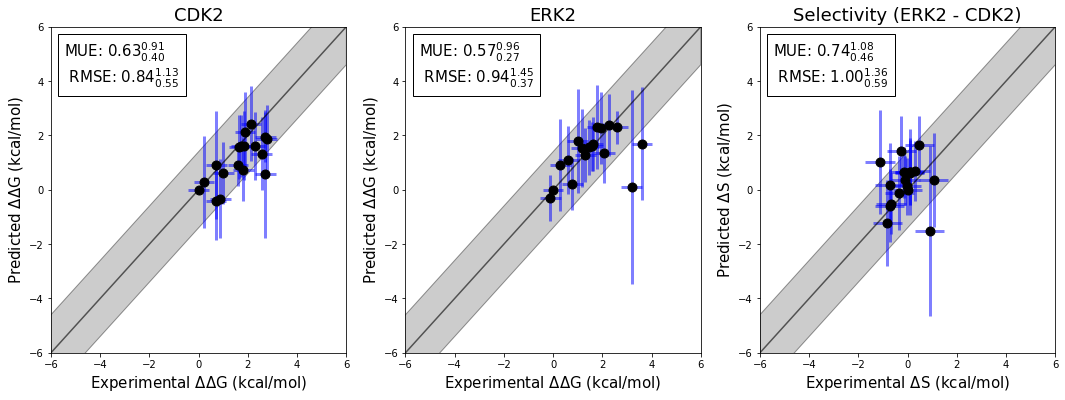

In [9]:
fig = plt.figure(figsize=(18,6))
x = np.array(range(-14, 7))
y = np.array(range(-14, 7))
ax = fig.add_subplot(1,3,1)
edge_color = matplotlib.colors.colorConverter.to_rgba('blue', alpha=.5)
x_points = DeltaG_exp_1
y_points = DeltaG_CC_1
yerr = dDeltaG_stat_1 + dDeltaG_systematic_1
RMSE = math.sqrt(mean_squared_error(x_points, y_points))
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_1, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_1, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_1, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_1, [2.5, 97.5])[0]), 
                    loc=2, prop=dict(fontsize=15))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
ax.errorbar(x_points, y_points, xerr=0.42,yerr=yerr, fmt='o', c='black', ecolor=edge_color, elinewidth=3, markersize=9)
ax.add_artist(text)
ax.set_title('CDK2', fontsize=18)
plt.ylim(-6,6)
plt.xlim(-6,6)
plt.xlabel('Experimental $\Delta \Delta$G (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta \Delta$G (kcal/mol)', fontsize=15)


ax = fig.add_subplot(1,3,2)
x = np.array(range(-14, 7))
y = np.array(range(-14, 7))
x_points = DeltaG_exp_2
y_points = DeltaG_CC_2
yerr = dDeltaG_stat_2 + dDeltaG_systematic_2
RMSE = math.sqrt(mean_squared_error(x_points, y_points))
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_2, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_2, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_2, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_2, [2.5, 97.5])[0]), 
                    loc=2, prop=dict(fontsize=15))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
# for point in range(len(x_points)):
#     e = Ellipse(xy=(x_points[point],y_points[point]), width=0.3, height=yerr[point])
#     ax.add_artist(e)
#     e.set_facecolor('blue')
#     e.set_alpha(.3)
#     e.set_edgecolor('blue')
#ax.errorbar(x_points, y_points, xerr=0.3, yerr=np.sqrt(yerr**2 + 0.9 **2), fmt='o', c='black', ecolor='blue', alpha=.6)
ax.errorbar(x_points, y_points, xerr=0.42,yerr=yerr, fmt='o', c='black', ecolor=edge_color, elinewidth=3, markersize=9)
ax.add_artist(text)
ax.set_title('ERK2', fontsize=18)
plt.ylim(-6,6)
plt.xlim(-6,6)
plt.xlabel('Experimental $ \Delta \Delta$G (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta \Delta$G (kcal/mol)', fontsize=15)


ax = fig.add_subplot(1,3,3)
x = np.array(range(-6, 8))
y = np.array(range(-6, 8))
ax.plot(x,y, ls="-", c="black", alpha=.6)
ax.fill_between(x, y - 1.4, y+1.4, facecolor='gray', edgecolor='black', alpha=.4, linewidth=1)
x_points = selectivity_exp_set1
y_points = selectivity_pred_set1
yerr = selectivity_pred_systematic_set1
RMSE = math.sqrt(mean_squared_error(x_points, y_points))
MUE = mean_absolute_error(x_points, y_points)
text = AnchoredText('MUE: $%.2f^{%.2f}_{%.2f}$ \n RMSE: $%.2f^{%.2f}_{%.2f}$' % (MUE, 
                                                                                 np.percentile(mue_selectivity, [2.5, 97.5])[1], 
                                                                                 np.percentile(mue_selectivity, [2.5, 97.5])[0], 
                                                                                 RMSE, 
                                                                                 np.percentile(rmse_selectivity, [2.5, 97.5])[1], 
                                                                                 np.percentile(rmse_selectivity, [2.5, 97.5])[0]), loc=2, prop=dict(fontsize=15))
# for point in range(len(x_points)):
#     e = Ellipse(xy=(x_points[point],y_points[point]), width=2*0.42, height=2*yerr[point])
#     ax.add_artist(e)
#     e.set_facecolor('blue')
#     e.set_alpha(.3)
#     e.set_edgecolor('blue')
#ax.errorbar(x_points, y_points, xerr=0.42, yerr=np.sqrt(yerr**2 + 0.9 **2), fmt='o', c='black', ecolor='blue', alpha=.6)
edge_color = matplotlib.colors.colorConverter.to_rgba('blue', alpha=.5)
ax.errorbar(x_points, y_points, xerr=np.sqrt(2 * (0.42**2)),yerr=yerr, fmt='o', c='black', ecolor=edge_color, elinewidth=3, markersize=9)
ax.add_artist(text)
plt.xlabel('Experimental $\Delta$S (kcal/mol)', fontsize=15)
plt.ylabel('Predicted $\Delta$S (kcal/mol)', fontsize=15)
ax.set_title('Selectivity (ERK2 - CDK2)', fontsize=18)
plt.ylim(-6,6)
plt.xlim(-6,6)

fig.savefig('cdk2_erk2_replicate2_systematic_ccparam.pdf', dpi=500, bbox_inches='tight')